In [19]:
import netket as nk
import jax
from netket.operator.spin import sigmax,sigmaz, sigmap, sigmam
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt
import time
from oneD_tool import *

L = 16
hi = nk.hilbert.Spin(s=1 / 2, N=L)
J2_ = [0.2, 0.4, 0.48, 0.52, 0.6, 0.7, 0.9, 1.0, 1.05, 1.2]
periodic = True
for J2 in J2_:
    H = sum([2*(sigmap(hi,i)*sigmam(hi,(i+1))+sigmam(hi,i)*sigmap(hi,(i+1))) + sigmaz(hi, i)*sigmaz(hi, (i+1))   for i in range(L-1)])
    H += J2*sum([2*(sigmap(hi,i)*sigmam(hi,(i+2))+sigmam(hi,i)*sigmap(hi,(i+2))) + sigmaz(hi, i)*sigmaz(hi, (i+2))   for i in range(L-2)])
    if periodic:
        H += 2*(sigmap(hi,0)*sigmam(hi,L-1)+sigmam(hi,0)*sigmap(hi,L-1))+sigmaz(hi,0)*sigmaz(hi,L-1)
        H += J2*2*(sigmap(hi,0)*sigmam(hi,L-2)+sigmam(hi,0)*sigmap(hi,L-2))+J2*sigmaz(hi,0)*sigmaz(hi,L-2)
        H += J2*2*(sigmap(hi,L-1)*sigmam(hi, 1)+sigmam(hi,L-1)*sigmap(hi, 1))+J2*sigmaz(hi,L-1)*sigmaz(hi,1)
    sp_h = H.to_sparse()
    eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
    print("eigenvalues with scipy sparse:", eig_vals)
    probs_exact =  np.abs(eig_vecs[:, 0]) ** 2
    mag = np.sum(probs_exact*np.array(count_diff_ones_zeros(L)))
    shape = (2,) * (L)
    probs_exact = probs_exact.reshape(*shape)

    if (periodic == False):
        cmi = cmi_(probs_exact, L)
        mean_corr, var_corr = spin_correlation_all(probs_exact, L)

    else:
        cmi = cmi_periodic(probs_exact, L)
        mean_corr = spin_correlation_periodic(probs_exact, L)
    cmi_all = cmi_traceout(probs_exact, L)
    np.save("result/1DJ1J2/cmi_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", cmi)
    np.save("result/1DJ1J2/mean_corr_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", mean_corr)
    if periodic == False:
        np.save("result/1DJ1J2/var_corr_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", var_corr)
    np.save("result/1DJ1J2/cmi_traceout_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", cmi_all)
    np.save("result/1DJ1J2/mag_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", mag)
    np.save("result/1DJ1J2/gap_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".npy", np.array(eig_vals[1]-eig_vals[0]))


eigenvalues with scipy sparse: [-26.3084813  -25.35569415]
eigenvalues with scipy sparse: [-24.43752226 -24.16118222]
eigenvalues with scipy sparse: [-24.02667416 -24.00181035]
eigenvalues with scipy sparse: [-24.0178725  -24.01203076]
eigenvalues with scipy sparse: [-24.39009611 -24.3523718 ]
eigenvalues with scipy sparse: [-25.49248227 -25.34443569]
eigenvalues with scipy sparse: [-29.039338   -28.70015396]
eigenvalues with scipy sparse: [-31.06648562 -31.04162281]
eigenvalues with scipy sparse: [-32.34215522 -32.0744129 ]
eigenvalues with scipy sparse: [-36.35526144 -35.2702526 ]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
# Dictionary to store the loaded array

cmi = {}
mean_corr= {}
var_corr = {}
gap = {}
cmi_traceout = {}
mag = {}
# Looping through the values and loading each file
for b in J2_:
    filename = f"result/1DJ1J2/cmi_1DJ1J2_L{L}_J2_{b}periodic_{periodic}.npy"
    cmi[b] = np.load(filename)
    if periodic == True:
        cmi[b] = np.flip(cmi[b])
    filename = f"result/1DJ1J2/mean_corr_1DJ1J2_L{L}_J2_{b}periodic_{periodic}.npy"
    mean_corr[b] = np.load(filename)
    if periodic == False:
        filename = f"result/1DJ1J2/var_corr_1DJ1J2_L{L}_J2_{b}periodic_{periodic}.npy"
        var_corr[b] = np.load(filename)
    filename = f"result/1DJ1J2/gap_1DJ1J2_L{L}_J2_{b}periodic_{periodic}.npy"
    gap[b] = np.load(filename)
    filename = f"result/1DJ1J2/cmi_traceout_1DJ1J2_L{L}_J2_{b}periodic_{periodic}.npy"
    cmi_traceout[b] = np.load(filename, allow_pickle=True)
    filename = f"result/1DJ1J2/mag_1DJ1J2_L{L}_J2_{b}periodic_{periodic}.npy"
    mag[b] = np.load(filename)


In [21]:
cmi_length = []
err_cmi_length =[]
corre_length = []
err_corre_length = []
cmi_length_traceout = [[] for i in range (len(J2_))]
err_cmi_length_traceout = [[] for i in range (len(J2_))]
for i in J2_:
    cmi[i] = np.abs(cmi[i])
    for j in range(len(cmi_traceout[i])):
        cmi_traceout[i][j] = np.abs(np.array(cmi_traceout[i][j]))
for i in J2_:
    df = len(cmi[i])-2
    (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi[i])), -np.log(cmi[i]), 1, full=True)
    mean_x = np.mean(np.arange(len(cmi[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi[i])) - mean_x)**2))
    cmi_length.append(cmi_len)
    err_cmi_length.append(err)

    (corr_len, b2), residuals, _, _, _ = np.polyfit(np.arange(len(mean_corr[i])), -np.log(np.abs(mean_corr[i])), 1, full=True)
    mean_x = np.mean(np.arange(len(mean_corr[i])))
    err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(mean_corr[i])) - mean_x)**2))
    corre_length.append(corr_len)
    err_corre_length.append(err)

    for j in range(len(cmi_traceout[i])):
        df = len(cmi_traceout[i][j])-2
        (cmi_len, b1), residuals, _, _, _ = np.polyfit(np.arange(len(cmi_traceout[i][j])), -np.log(cmi_traceout[i][j]+1e-32), 1, full=True)
        mean_x = np.mean(np.arange(len(cmi_traceout[i][j])))
        err = np.sqrt(residuals / df) / np.sqrt(np.sum((np.arange(len(cmi_traceout[i][j])) - mean_x)**2))
        cmi_length_traceout[J2_.index(i)].append(cmi_len)
        err_cmi_length_traceout[J2_.index(i)].append(err)

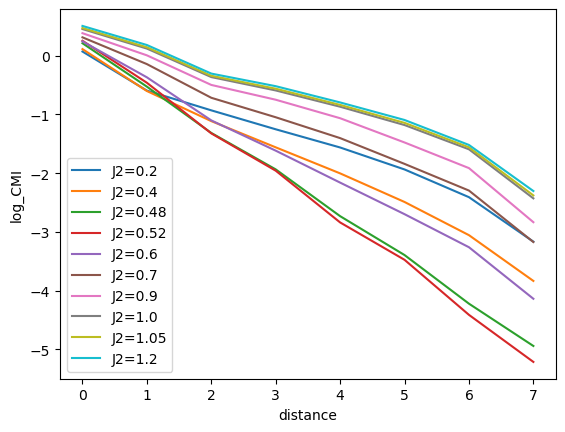

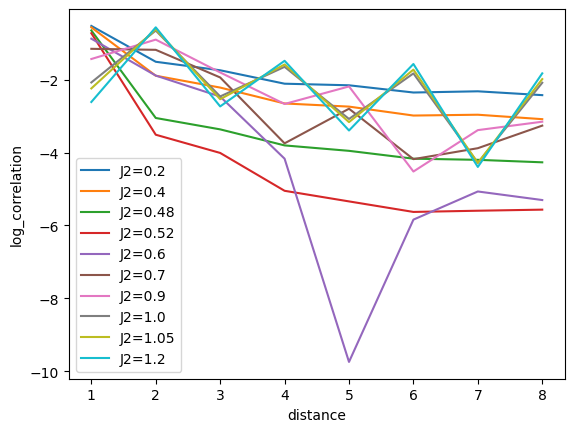

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


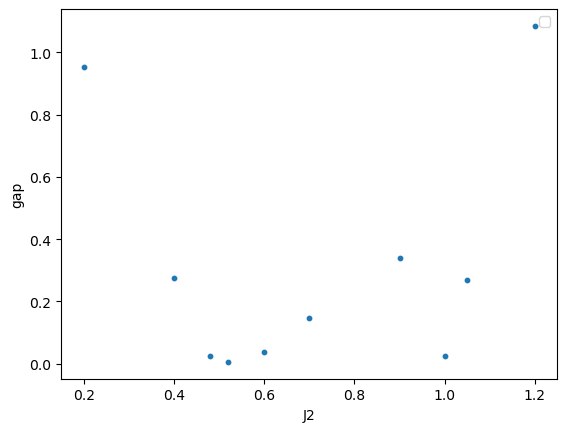

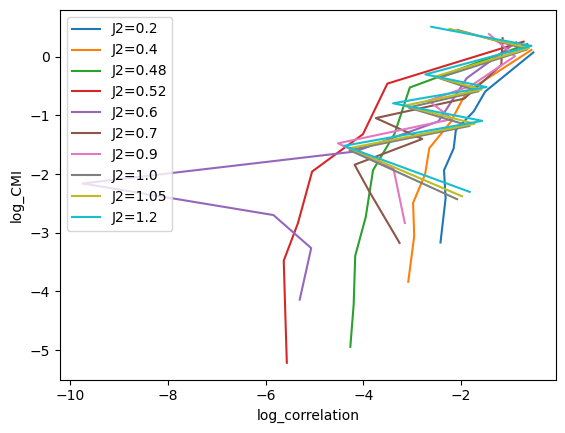

<Figure size 640x480 with 0 Axes>

In [22]:
for i in J2_:
    plt.plot(np.log(cmi[i]), label="J2="+str(i))
plt.xlabel("distance")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/1DJ1J2/cmi_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

for i in J2_:
    plt.plot(np.arange(len(mean_corr[i])-1)+1, np.log(mean_corr[i][1:]), label="J2="+str(i))
    if periodic == False:
        plt.fill_between(np.arange(len(mean_corr[i])-1)+1 ,np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("distance")
plt.ylabel("log_correlation")
plt.legend()
plt.savefig("figure/1DJ1J2/correlation_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

J2__ = [J2_[i] for i in range(len(J2_))]
plt.scatter(J2__, gap.values(), s=10)
plt.xlabel("J2")
plt.ylabel("gap")
plt.legend()
plt.savefig("figure/1DJ1J2/gap_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

for i in J2_:
    plt.plot(np.log(mean_corr[i][1:]), np.log(cmi[i]), label="J2="+str(i))
    if periodic == False:
        plt.fill_betweenx(np.log(cmi[i]), np.log(mean_corr[i][1:]) - 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]) , np.log(mean_corr[i][1:]) + 1/mean_corr[i][1:]*np.sqrt(var_corr[i][1:]), alpha=0.2)
plt.xlabel("log_correlation")
plt.ylabel("log_CMI")
plt.legend()
plt.savefig("figure/1DJ1J2/correlation_cmi_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()


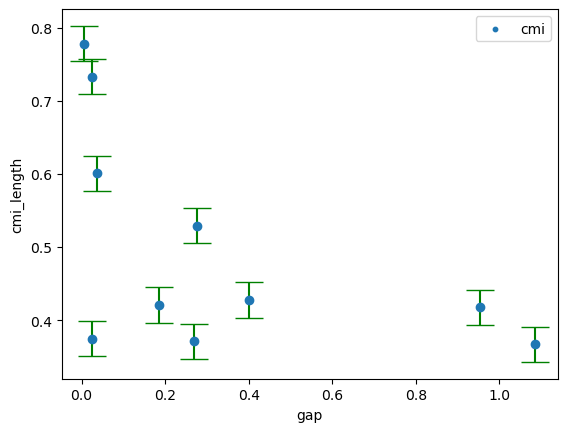

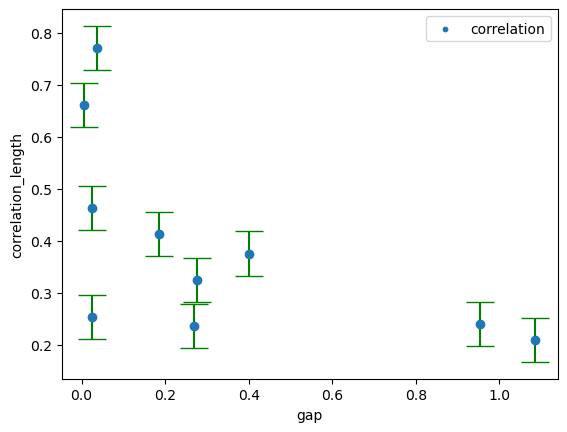

<Figure size 640x480 with 0 Axes>

In [18]:
gap_list = []
for i in J2_:
    gap_list.append(gap[i])

plt.scatter(gap_list, cmi_length, label="cmi", s=10)
plt.errorbar(gap_list, cmi_length, yerr=err_cmi_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("cmi_length")
plt.legend()
plt.savefig("figure/1DJ1J2/cmi_length_gap_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

plt.scatter(gap_list, corre_length, label="correlation", s=10)
plt.errorbar(gap_list, corre_length, yerr=err_corre_length[:][0], fmt='o', ecolor='g', capthick=1, capsize=10)
plt.xlabel("gap")
plt.ylabel("correlation_length")
plt.legend()
plt.savefig("figure/1DJ1J2/correlation_length_gap_1DJ1J2_L"+str(L)+"_J2_"+str(J2)+"periodic_"+str(periodic)+".png")
plt.show()
plt.clf()

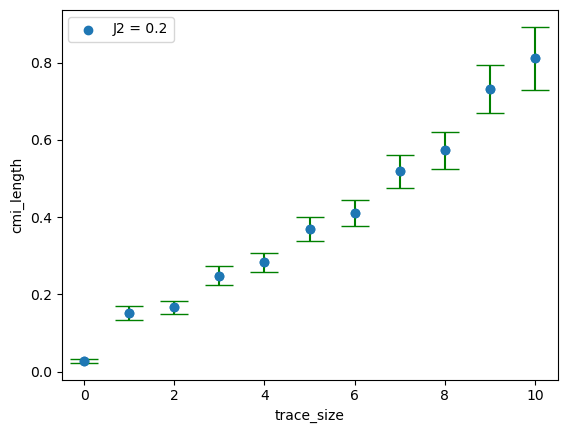

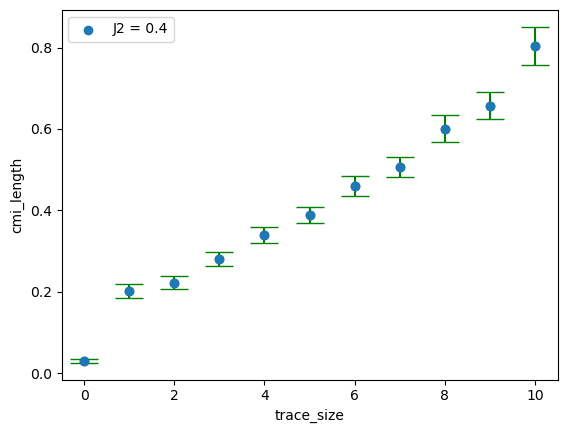

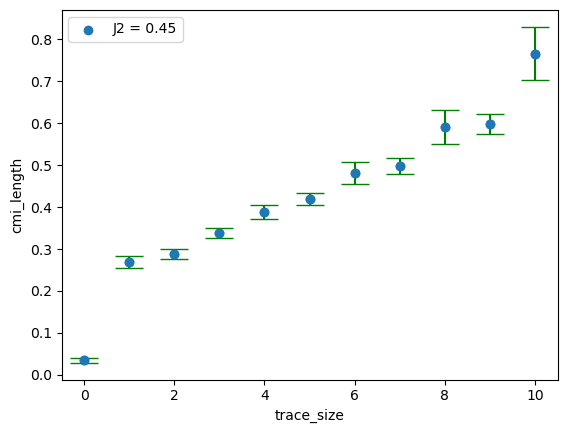

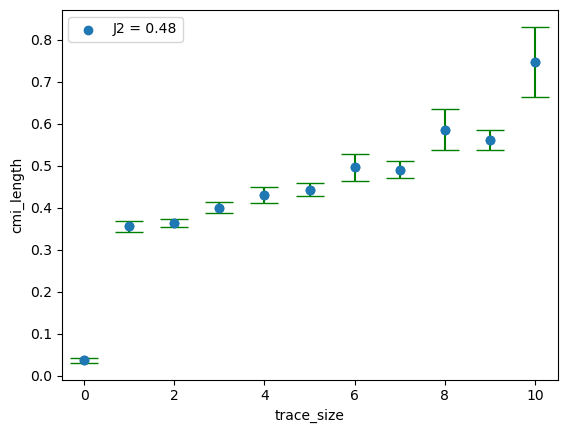

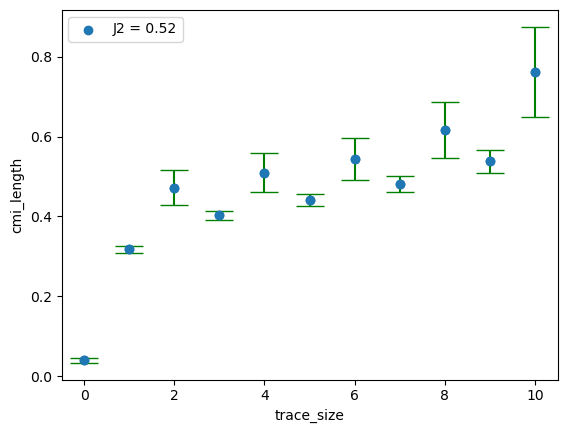

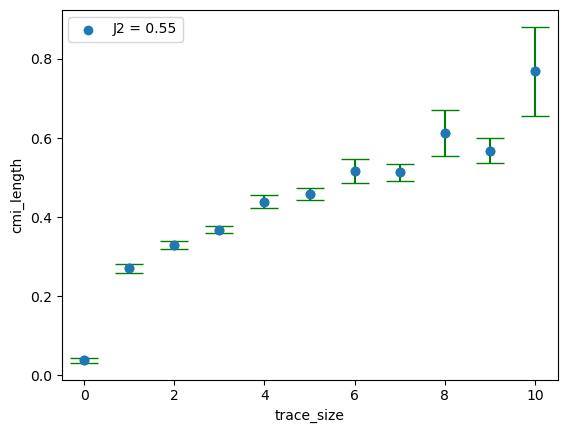

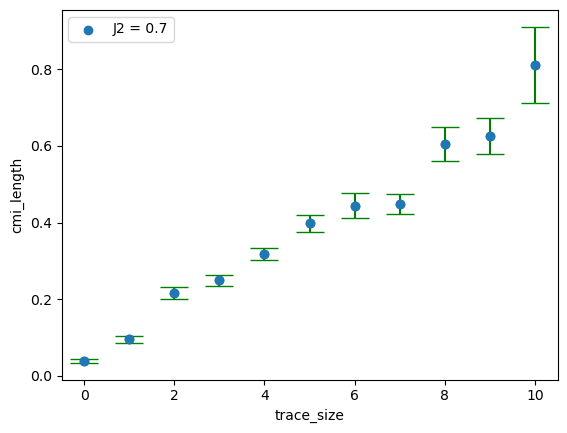

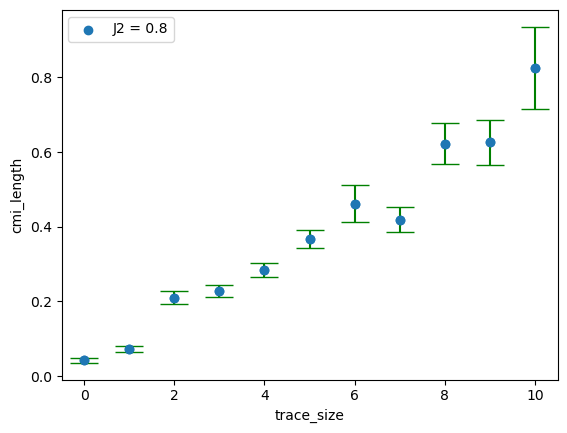

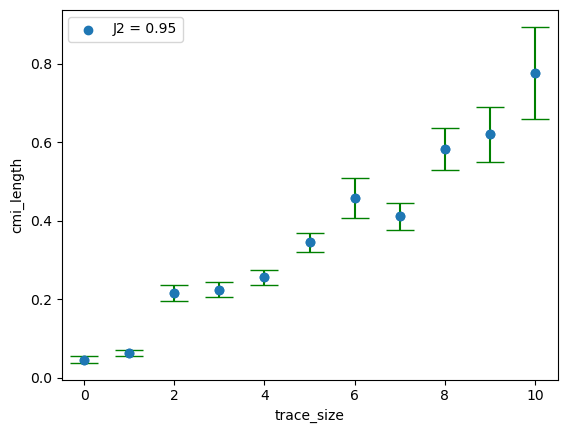

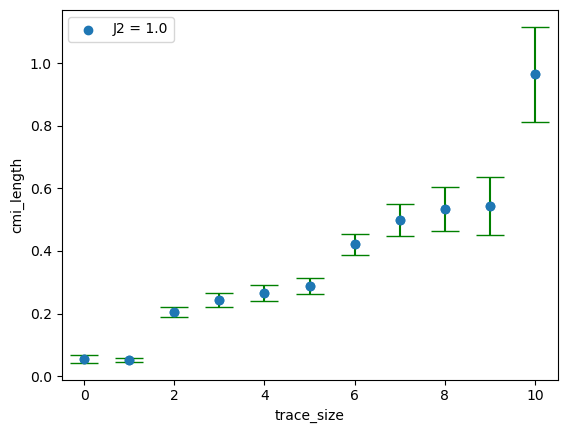

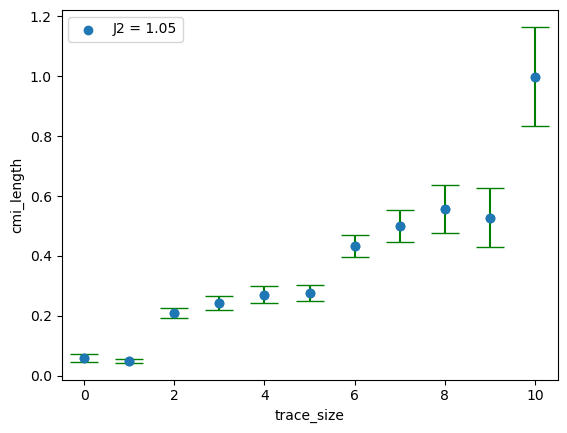

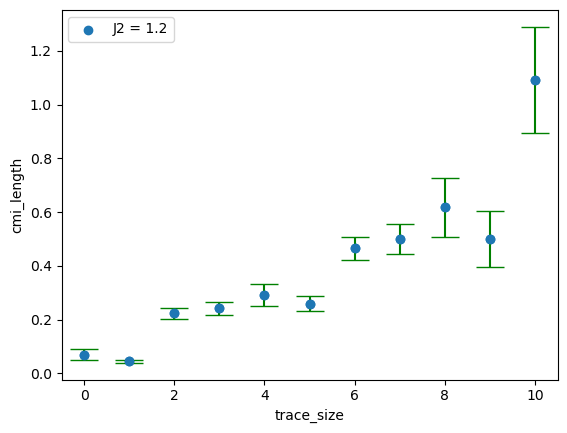

<Figure size 640x480 with 0 Axes>

In [10]:
for i in range(len(J2_)):
    plt.scatter(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], label="J2 = "+str(J2_[i]))
    plt.errorbar(np.arange(len(cmi_length_traceout[i])), cmi_length_traceout[i], yerr=np.array(err_cmi_length_traceout[i]).ravel(), fmt='o', ecolor='g', capthick=1, capsize=10)
    plt.xlabel("trace_size")
    plt.ylabel("cmi_length")
    plt.legend()
    plt.savefig("figure/1DJ1J2/traceout/cmi_length_traceout_1DJ1J2_L"+str(L)+"_J2_"+str(J2_[i])+"periodic_"+str(periodic)+".png")
    plt.show()
    plt.clf()